In [182]:
import os
import warnings
import torch
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np

from torch import nn
from torch.utils.data import Dataset, DataLoader

In [183]:
# Download and Save MNIST 
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('~/mnist_data', train=False, download=True, transform = transforms.ToTensor())
len(mnist),len(mnist_test)

(60000, 10000)

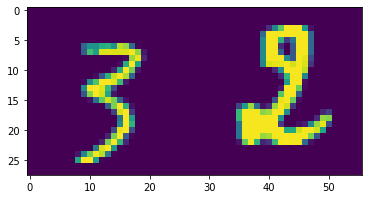

In [184]:
mnist[1][0]
img = torch.cat((mnist[878][0],mnist[36875][0]),2)
plt.imshow(img.squeeze())

In [185]:
input_size = 1568
output_size = 100

In [186]:
def train_test_split(data,split_train = 0.70):
    trainSize = int(len(data)*split_train)
    validationSize = len(data) - trainSize
    
    trainData, valData = torch.utils.data.random_split(data, [trainSize, validationSize])
    
    return trainData,valData

mnist_train , mnist_validation = train_test_split(mnist,0.70)

len(mnist_train), len(mnist_validation) # Number of Images in each set

(42000, 18000)

In [187]:
train_loader = torch.utils.data.DataLoader(mnist_train , batch_size = 10, shuffle = False)
validation_loader = torch.utils.data.DataLoader(mnist_validation , batch_size = 10, shuffle = False)
test_loader = torch.utils.data.DataLoader(mnist_test , batch_size = 10 , shuffle = False)

len(train_loader),len(validation_loader),len(test_loader)

(4200, 1800, 1000)

In [188]:
class DNN(nn.Module):  #A ReLU DNN with 3 hidden layers of size 300, 100 and 50.
    def __init__(self):
        super().__init__()
        self.input_size = input_size
        self.network = nn.Sequential(nn.Linear(1568,700),nn.ReLU(),nn.Linear(700,300),nn.ReLU(),nn.Linear(300,150),nn.ReLU(),nn.Linear(150,100),nn.LogSoftmax(dim=1))
        
    def forward(self,x):
        x = x.view(-1, self.input_size)
        return self.network(x)
        return x
    
model = DNN()

In [189]:
# def cr_two_dg_images(images, labels):
#     new_images = torch.empty((images.size(0)*images.size(0), images.size(1), images.size(2), images.size(3)*2))
#     new_labels = torch.empty(labels.size(0)*images.size(0))
#     for i in range(images.size(0)):
#         for j in range(images.size(0)):
#             img = torch.cat((images[i],images[j]), dim=2)
#             lab = labels[i]*10 + labels[j]
#             new_images[i*10 + j] = img
#             new_labels[i*10 + j] = lab

#     return new_images, new_labels.to(int)

In [190]:
def DatasetGen(tuple_data):
    images,labels = tuple_data
    new_images = torch.empty((images.size(0)*images.size(0), images.size(1), images.size(2), images.size(3)*2))
    new_labels = torch.empty(labels.size(0)*images.size(0))
    for i in range(images.size(0)):
        for j in range(images.size(0)):
            img = torch.cat((images[i],images[j]), dim = 2)
            lab = labels[i]*10 + labels[j]
            new_images[i*10 + j] = img
            new_labels[i*10 + j] = lab
    return new_images, new_labels.to(float)

In [191]:
# def DatasetGen(tuple_data):
#     double_img = []
#     double_lab = []
#     for j in range(len(tuple_data[1])):
#         for k in range(len(tuple_data[1])):
#             img_new = torch.cat((tuple_data[0][j],tuple_data[0][k]),dim = 2)
#             label_new = int(10*tuple_data[1][j].item()+tuple_data[1][k].item())
#             double_img.append(img_new.flatten())
#             double_lab.append(label_new)
#     return double_img,double_lab

In [192]:
# #counter = 0
# for i,(input,output) in enumerate(train_loader):
#     data = DatasetGen((input,output))
    
# len(data)

In [193]:
# f = np.random.randint(59000 , size = 20)
# for k in f:
#     #print(k)
#     plt.imshow(data[k][0].squeeze())
#     plt.show()
#     print(data[k][1])

In [194]:
epoch_no = 5

def train_model(train_loader,validation_loader,model):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
    
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
     
    
    
    for epochs in range(1,epoch_no+1):
        training_loss = 0
        validation_loss = 0
        training_accuracy = 0
        validation_accuracy = 0
        total_n_train = 0
        total_n_val = 0
        for i,data in enumerate(train_loader):
            # train_double_mnist = 
            inputs,targets = DatasetGen(data)
            model.train()
            # inputs = inputs.squeeze()
            
            flattened_input = torch.flatten(inputs, start_dim = 1)
            
            optimizer.zero_grad()
            output = model(flattened_input)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output,targets)
            loss.backward()
            optimizer.step()
            
            total_n_train += flattened_input.size(0)
            training_loss += loss.item() * flattened_input.size(0)
            training_accuracy += torch.sum(preds == targets.data)
            
        train_loss.append(training_loss/total_n_train)
        train_accuracy.append(training_accuracy/total_n_train)
        
        for i,data in enumerate(test_loader):
            
            inputs,targets =  DatasetGen(data)
            model.eval()
            # inputs = inputs.squeeze()
            
            flattened_input = torch.flatten(inputs, start_dim = 1)
            
            optimizer.zero_grad()
            output = model(flattened_input)
            _, preds = torch.max(output.data , 1)
            loss = criterion(output,targets)
            
            loss.backward()
            optimizer.step()
            
            total_n_val += flattened_input.size(0)
            validation_loss += loss.item() * flattened_input.size(0)
            validation_accuracy += torch.sum(preds == targets.data)
            
        
        val_loss.append(validation_loss/total_n_val)
        val_accuracy.append(validation_accuracy/total_n_val)
        
        
    return train_loss,val_loss,train_accuracy,val_accuracy,inputs,targets,preds
    

In [195]:
train_loss,val_loss , train_accuracy,val_accuracy,inp,tar,pre = train_model(train_loader,validation_loader, model)

RuntimeError: expected scalar type Long but found Double

In [ ]:
len(train_accuracy)

5

In [ ]:
print("train accuracy is {:.4f}, valid accuracy is {:.4f}".format(train_accuracy[-1].item(),val_accuracy[-1].item()))

train accuracy is 0.1943, valid accuracy is 0.1954


In [ ]:
train_accuracy #,val_accuracy

[tensor(0.7059),
 tensor(0.4575),
 tensor(0.3151),
 tensor(0.2404),
 tensor(0.1943)]

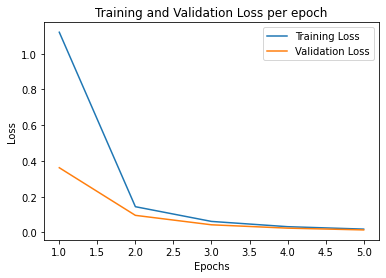

In [ ]:
epochs = [i for i in range(1,epoch_no+1)]
plt.plot(epochs,train_loss,label = "Training Loss")
plt.plot(epochs,val_loss,label = "Validation Loss")
plt.title('Training and Validation Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
def test_nn(test_loader,model):
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = []
    test_accuracy = []
    testing_loss = 0
    testing_accuracy = 0 
    total_n = 0
    for i, data in enumerate(test_loader):
        inputs,targets =  DatasetGen(data)
        model.eval()
        #inputs = inputs.squeeze()
        
        flattened_input = torch.flatten(inputs, start_dim=1)

        output = model(flattened_input)
        _, preds = torch.max(output.data, 1)
        loss = criterion(output,targets)
        
        total_n += flattened_input.size(0)
        testing_loss += loss.item() * flattened_input.size(0)
        testing_accuracy += torch.sum(preds == targets.data)

    test_loss.append(testing_loss/total_n)
    test_accuracy.append(testing_accuracy/total_n)
    
    return test_loss, test_accuracy ,total_n

In [ ]:
test_loss,test_accuracy,total_n = test_nn(test_loader,model)
print("The test accuracy is given by {:.4f}".format(test_accuracy[-1].item()))
# print(total_n)

The test accuracy is given by 0.9466


In [ ]:
test_accuracy

[tensor(0.9466)]